In [1]:
import warnings; warnings.simplefilter('ignore')

In [2]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import pystan
from datetime import datetime, timedelta

from time import sleep
import os
from IPython.display import display

%matplotlib inline 

In [3]:
%load_ext autoreload
%autoreload 2

from functions.helper_functions import (StanModel_cache,
                                        vb, model_dict,
                                        get_sector_assignment_dict,)

run_in_parallel = False

<h3>Run the following cell, if you want to run different models in parallel, otherwise skip the cell.</h3>
<p>Before running the cell, start clusters. E.g. run 'ipcluster start -n 4'.</p>
<p>More information on: https://ipyparallel.readthedocs.io/en/latest/intro.html#getting-started </p>

In [4]:
import ipyparallel as ipp

rc = ipp.Client()
dview = rc.load_balanced_view()

with rc[:].sync_imports():
    import numpy as np
    import pandas as pd
    import pystan
    from functions.helper_functions import (vb, model_dict)
print(rc.ids)

run_in_parallel = True

importing numpy on engine(s)
importing pandas on engine(s)
importing pystan on engine(s)
importing vb,model_dict from functions.helper_functions on engine(s)
[0, 1, 2, 3]


<h1>Load Data</h1>

In [5]:
N = 25  # max: 120

data = pd.read_csv('crypto_portfolio.csv', index_col='Date', parse_dates=['Date']).iloc[:250,:N]
data = data.drop(columns=['CL=F', 'AAPL','^GDAXI','TSLA','^IXIC'])
sector_assignments = pd.read_csv('example_data/sector_assignments_17_18.csv', index_col=0).values.squeeze()[:N]

stock_list = data.columns

print( "number of nan's: {}".format(data.isna().sum().sum()) )
print( "shape data: {}".format(data.shape) )
display(data.head())

number of nan's: 0
shape data: (250, 20)


,XLM-USD,BCH-USD,ADA-USD,LTC-USD,BTC-USD,XRP-USD,MANA-USD,BAT-USD,USDT-USD,ETH-USD,FIL-USD,BNT-USD,BNB-USD,ZEC-USD,XMR-USD,DOGE-USD,DASH-USD,MIOTA-USD,TRX-USD,THETA-USD
Date,,,,,,,,,,,,,,,,,,,,
2018-01-30,-0.169078,-0.112598,-0.146487,-0.090210,-0.105352,-0.140041,-0.157442,-0.161097,-0.008875,-0.094075,-0.014966,-0.116169,-0.118595,-0.145205,-0.134581,-0.135352,-0.118246,-0.138811,-0.159998,-0.231703
2018-01-31,0.102418,0.011111,-0.023684,-0.011647,0.011359,0.020930,0.126620,0.015149,0.003840,0.044047,0.015528,0.033437,-0.009395,0.037572,-0.004113,-0.002324,0.030357,0.040288,0.012890,0.006393
2018-02-01,-0.154395,-0.142943,-0.188023,-0.128888,-0.102783,-0.171939,-0.202484,-0.106391,-0.003368,-0.072896,-0.047941,-0.070738,-0.146179,0.007191,-0.116985,-0.163228,-0.115301,-0.173867,-0.151082,-0.116124
2018-02-02,-0.112563,-0.065296,-0.073844,-0.076727,-0.037052,-0.080773,-0.065286,-0.099226,0.003858,-0.116711,0.053420,-0.096357,0.014339,-0.042903,-0.022140,-0.110161,-0.048880,-0.051861,-0.117421,-0.107118
2018-02-03,0.061670,0.068304,0.123682,0.219754,0.038973,0.044371,0.113576,0.077764,0.010662,0.052670,-0.050898,0.044118,0.010090,0.013026,0.067725,0.153966,0.086035,0.100368,0.090027,0.094530


<h1>Compile Stan Code</h1>

In [6]:
file = "functions/stan_gplvm_finance.stan"
with open(file) as f:
    stan_code = f.read()

stan_model = StanModel_cache(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6d19870ce519fbd897c6f818f9fb27ba NOW.


<h1>Train Model</h1>

In [7]:
def run_calc(model_name, Q, num):
    #shared variables: N, D, Y, model_dict, stan_model, tries
    import pandas as pd
    data_dict = {'N':N, 'D':D, 'Q':Q, 'Y':Y, 'model_number':model_dict[model_name]}
    n_error, should_break, n_error_max = 0, False, 5
    while n_error<n_error_max:    # sometimes, bad initialization leads to RuntimeError, 
                                  # if more then 5 times: break.
        try:
            diagnostic, sample = vb(data_dict, stan_model, tries=tries, num=num)
            n_error = n_error_max
        except RuntimeError:
            n_error += 1
            if n_error == n_error_max: should_break = True
            print('RuntimeError')

    if should_break:
        print('RuntimeError occurred too often.')
        return None
    elbo = diagnostic.loc[:, 'ELBO'].values[-1]
    X = sample.filter(regex='^X.\d{1,4}.\d{1,3}$') \
                .mean(axis=0).values.reshape(Q, N).T
    r2 = sample.filter(regex='^R2_hat_N$').mean(axis=0).values.squeeze()
    lengthscale = sample.filter(regex='^kernel_lengthscale$')\
        .mean(axis=0).values.squeeze()
    
    #print('elbo:{}\nr2:{}\nlengthscale:{}'.format(elbo, r2, lengthscale))
    #col_names = ['model_name', 'Q', 'ELBO', 'R2', 'inv_lengthscale']
    #df = pd.DataFrame({num: (model_name, Q, elbo, r2, inv_lengthscale)}, index=col_names).T
    return model_name, elbo, X

<h2>Specify parameter</h2>
<p>to get a better convergence, increase 'tries'. Note that $Y \in \mathbb{R}^{N \times D}$ is data.T</p>

In [8]:
Y = data.T.values
N, D = Y.shape
tries = 20
Qs = [2]

model_names = ['linear', 'squared_exp', 'squared_exp_m_linear', 'matern32']

inp = [(model_name, Q) for model_name in model_names for Q in Qs]

randint = np.random.randint(0, 1e+5)       
inp = [[*el, i+randint] for i, el in enumerate(inp)]
print('number inputs: {}'.format(len(inp)))

number inputs: 4


<hr>
<h4>If ipyparallel is imported the runs are distributed among all CPUs
otherwise inp-list is processed sequentially</h4>
<p>Note: if the list of inputs is too long and you not running ipyparallel, it might take a lot of time</p>

In [9]:
%%time
if run_in_parallel:
    async_res = []
    ids = []

    rc[:].push(dict(N=N, D=D, Y=Y, stan_model=stan_model, tries=tries,), block=True)

    for param in inp:
        re = dview.apply_async(run_calc, *param)
        async_res.append(re)
        ids.extend(re.msg_ids)

    # display progress
    sleep(10)
    while True:
        print(str(len(rc.result_status(ids)['pending'])) +"/"
              +str(len(rc.result_status(ids)['pending'])
                   +len(rc.result_status(ids)['completed']))
              +" still running. on " + str(len(rc.ids)) + " cores", end="\r")
        sleep(10)
        if len(rc.result_status(ids)['pending']) == 0: break
    
    
    # collect results 
    results = [r.get() for r in async_res]
    
    
else:
    # to get rid of the stan-warnings comment out the warning lines (second and 
    # third last line) in the pystan source code (file: pystan/model.py - vb() )
    # if you use a pickled model - recompile it after commenting out the lines
    
    results = []
    print('starting calculations ...', flush=True)
    for i, inp_ in enumerate(inp):
        results.append( run_calc(*inp_) )
        print('{}% done'.format( int(100*(i+1)/len(inp)) ), end='\r', flush=True)


CPU times: user 208 ms, sys: 43.3 ms, total: 252 ms
Wall time: 3min 20s


<h4>Display Results</h4>
<p>Only works for $Q=2$</p>

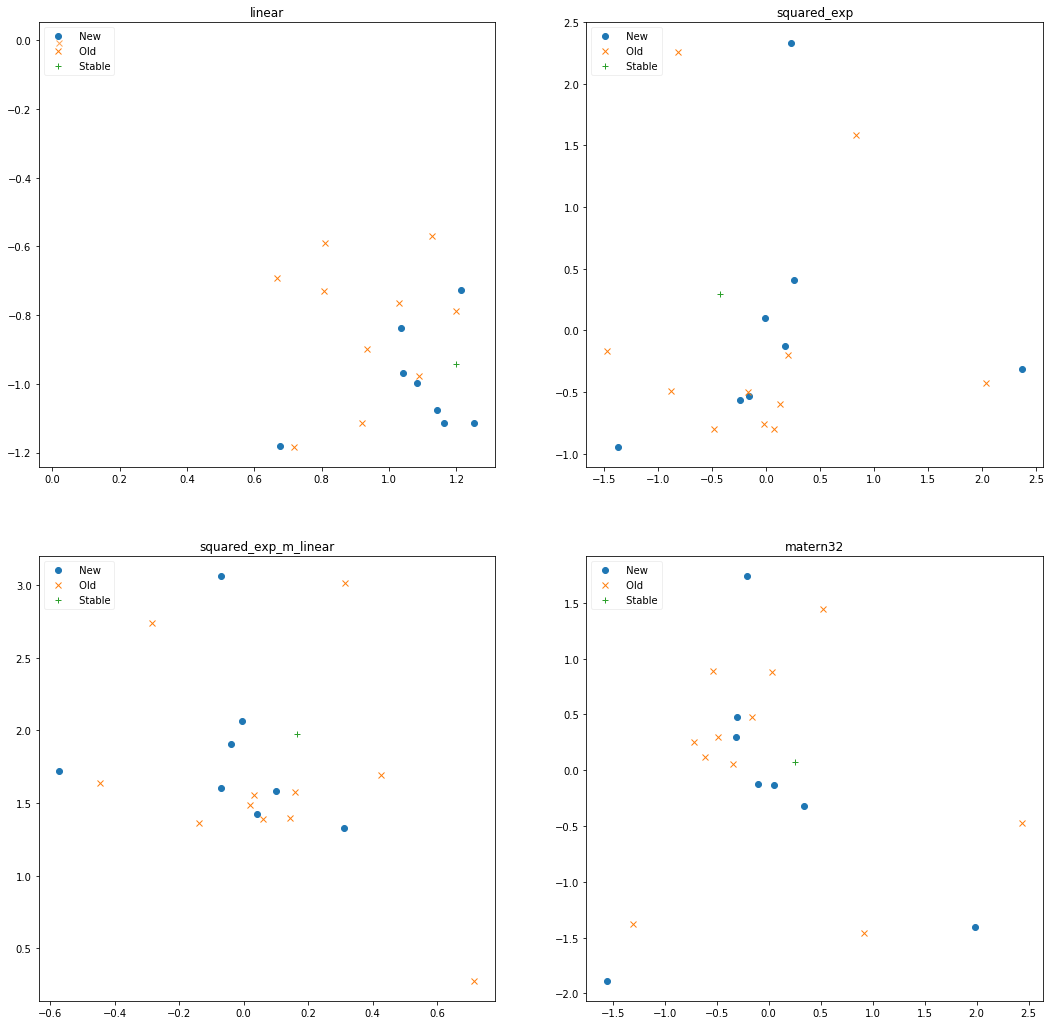

In [10]:
N_models = len(model_names)
fig = plt.figure(figsize=(9*N_models/2,18))
marker = ['o', 'x', '+', 'v', '^', '<', '>', 's', 'd', '.', ',']

for i, (model_name, _, X) in enumerate(results):
    df_X = pd.DataFrame(X, index=stock_list, columns=['X1', 'X2'])
    df_X['Sector'] = sector_assignments

    ax = fig.add_subplot(N_models/2,2,i+1)
    for i, (group_name, group_df) in enumerate(df_X.groupby(by='Sector')):
        ax.plot(group_df.loc[:, 'X1'], group_df.loc[:, 'X2'], marker[i], label="{}".format(group_name))

        
    ax.set_title(model_name)
    plt.legend(numpoints=1, framealpha=0.3, loc=2)
        
plt.show()

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components=2)
x = data.T.values
x = StandardScaler().fit_transform(x)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, index=stock_list
             , columns = ['X1', 'X2'], )

In [12]:
principalDf['Sector'] = sector_assignments
display(principalDf.head())

,X1,X2,Sector
XLM-USD,-0.730119,-0.892708,Old
BCH-USD,-2.190937,-0.087115,Old
ADA-USD,-2.835538,0.077297,New
LTC-USD,0.037215,-1.804913,Old
BTC-USD,2.977010,-3.696874,Old


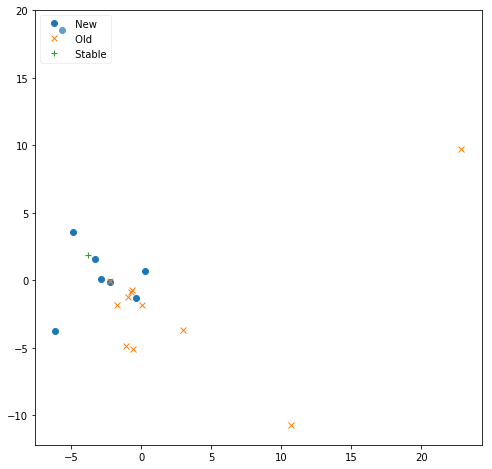

In [13]:
fig = plt.figure(figsize=(8,8))
marker = ['o', 'x', '+', 'v', '^', '<', '>', 's', 'd', '.', ',']
ax = fig.add_subplot(1,1,1)
for i, (group_name, group_df) in enumerate(principalDf.groupby(by='Sector')):
    ax.plot(group_df.loc[:, 'X1'], group_df.loc[:, 'X2'], marker[i], label="{}".format(group_name))

plt.legend(numpoints=1, framealpha=0.3, loc=2)
        
plt.show()